In [1]:
import pandas as pd
df = pd.read_csv('../raw_data/metadata_clean.csv')
lon, lat = df['lon'], df['lat']

In [14]:
from osgeo import gdal
dataset1 = gdal.Open('../maps/grdn40w121_1/w001001.adf')
dataset2 = gdal.Open('../maps/grdn39w121_1/w001001.adf')
arr = np.append(dataset1.ReadAsArray(), dataset2.ReadAsArray(), axis=0,)
geotransform = dataset1.GetGeoTransform()
origin = geotransform[0], geotransform[3]
dlon, dlat = geotransform[1], geotransform[5]



# Sun direction
azimuth=315.0
# Sun angle
altitude=45.0
# Elevation exageration
z=1.0
# Resolution
scale=1.0

xres = dlon*111.045e3 * np.cos(np.deg2rad(39.)) # resolution in m  correct for latitude
yres = -dlat*111.045e3 # resolution in m

print xres, yres

deg2rad = 3.141592653589793 / 180.0

# Exclude 2 pixels around the edges which are usually NODATA.
# Also set up structure for a 3x3 window to process the slope
# throughout the grid
window = []
for row in range(3):
    for col in range(3):
        window.append(arr[row:(row + arr.shape[0] - 2), col:(col + arr.shape[1] - 2)])

# Process each cell
x = ((z*window[0] + z*window[3] + z*window[3] + z*window[6]) - \
      (z*window[2] + z*window[5] + z*window[5] + z*window[8])) / (8.0*xres*scale);

y = ((z*window[6] + z*window[7] +z* window[7] + z*window[8]) 
     - (z*window[0] + z*window[1] + z*window[1] + z*window[2])) / (8.0*yres*scale);

# b = window[2] + 2*window[5] + window[8] - window[0] - 2*window[3] - window[6]/(8.0*xres)
# c = window[0] + 2*window[1] + window[2] - window[6] - 2*window[7] - window[8]/(8.0*yres)

# Calculate slope  
slope = 90.0 - np.rad2deg(np.arctan(np.sqrt(x*x + y*y)))
#slope = 90 - np.rad2deg(np.arctan(np.sqrt(b**2 + c**2)))

# Calculate aspect
aspect = np.arctan2(x, y)

# Calculate the shaded relief
shaded = np.sin(altitude * deg2rad) * np.sin(slope * deg2rad) \
 + np.cos(altitude * deg2rad) * np.cos(slope * deg2rad) \
 * np.cos((azimuth - 90.0) * deg2rad - aspect);
shaded = shaded * 255


23.9717148028 30.8458333334


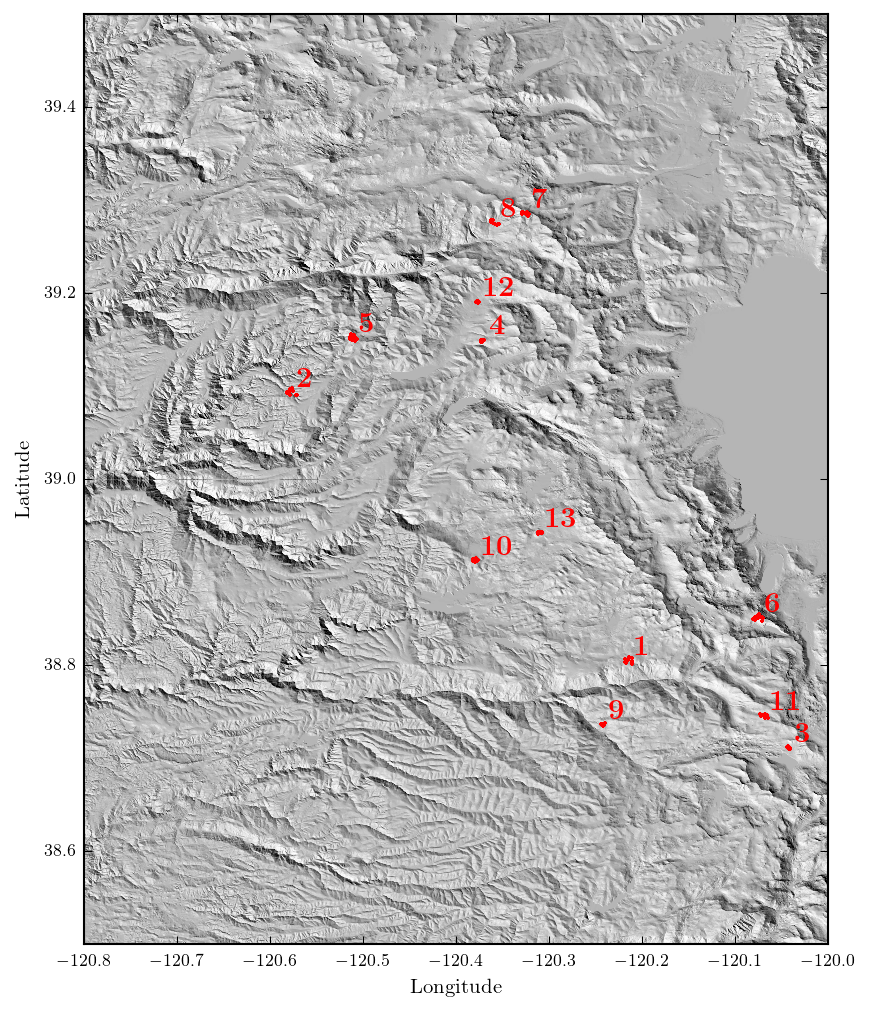

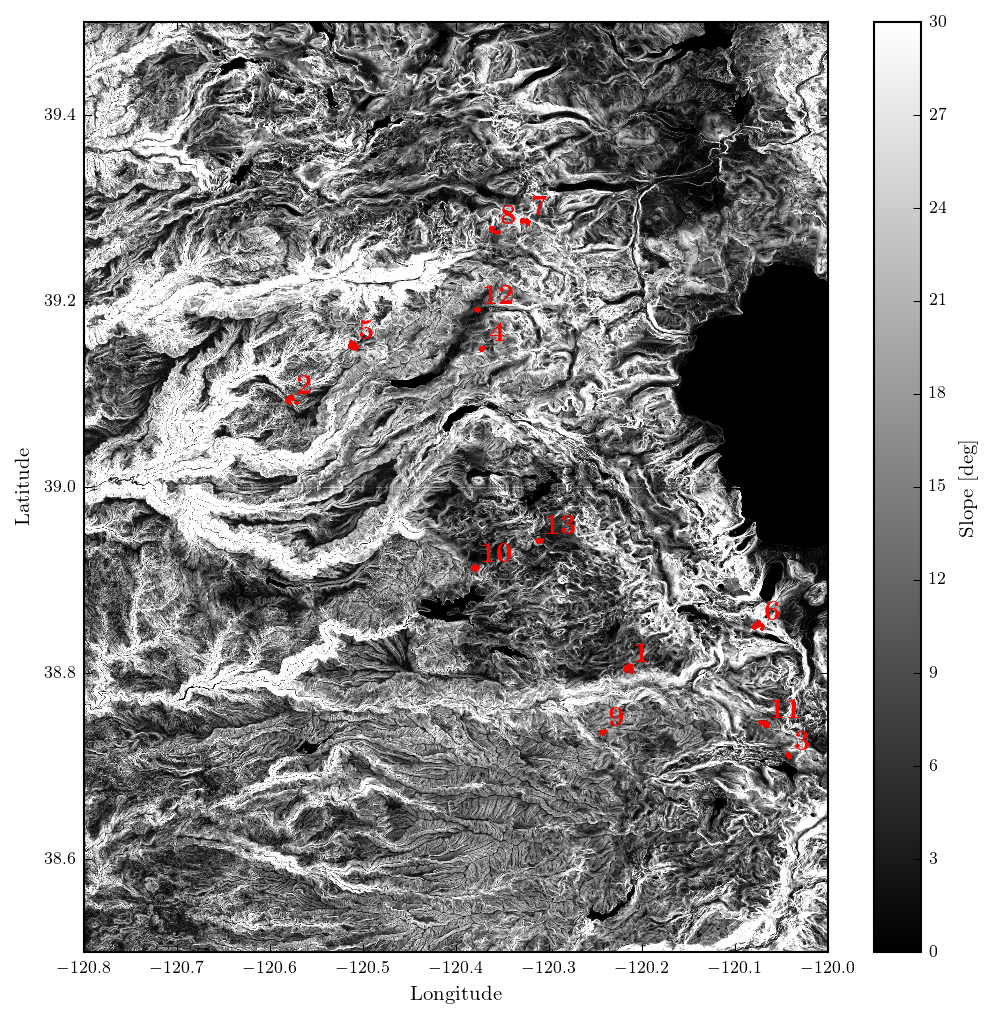

In [47]:


def PlotShaded(arr, vmin, vmax, cbar=False):
    plt.figure(figsize=(8,8))
    extent = [origin[0], origin[0]+dlon*shaded.shape[1], origin[1]+dlat*shaded.shape[0], origin[1]]
    #im = plt.imshow(arr,extent=extent,aspect=1, cmap='gray' , vmin=0)
    im = plt.imshow(arr,extent=extent,aspect=1, cmap='gray' , vmin=vmin, vmax=vmax,)
    if cbar:
        plt.colorbar(label='Slope [deg]')

    lon, lat = df['lon'], df['lat']
    plt.scatter(lon, lat, s=5, c='r', marker='+')
    plt.xlim(-120.8, -120 )
    plt.ylim(38.5, 39.5)
    plt.gca().ticklabel_format(useOffset=False)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

    n_sites = df['site_id'].max() 
    for i_site in range(1, n_sites+1):
        idx = df['site_id']==i_site
        lats, lons = df['lat'][idx], df['lon'][idx]
        mean_lon, mean_lat = np.mean(lons), np.mean(lats)
        plt.text(mean_lon+.007, mean_lat+.007, r'{\bf %i}'%i_site, color='r', fontsize=14)

PlotShaded(shaded, vmin=0, vmax=None, cbar=False)
PlotShaded(90-slope, vmin=0, vmax=30, cbar=True)

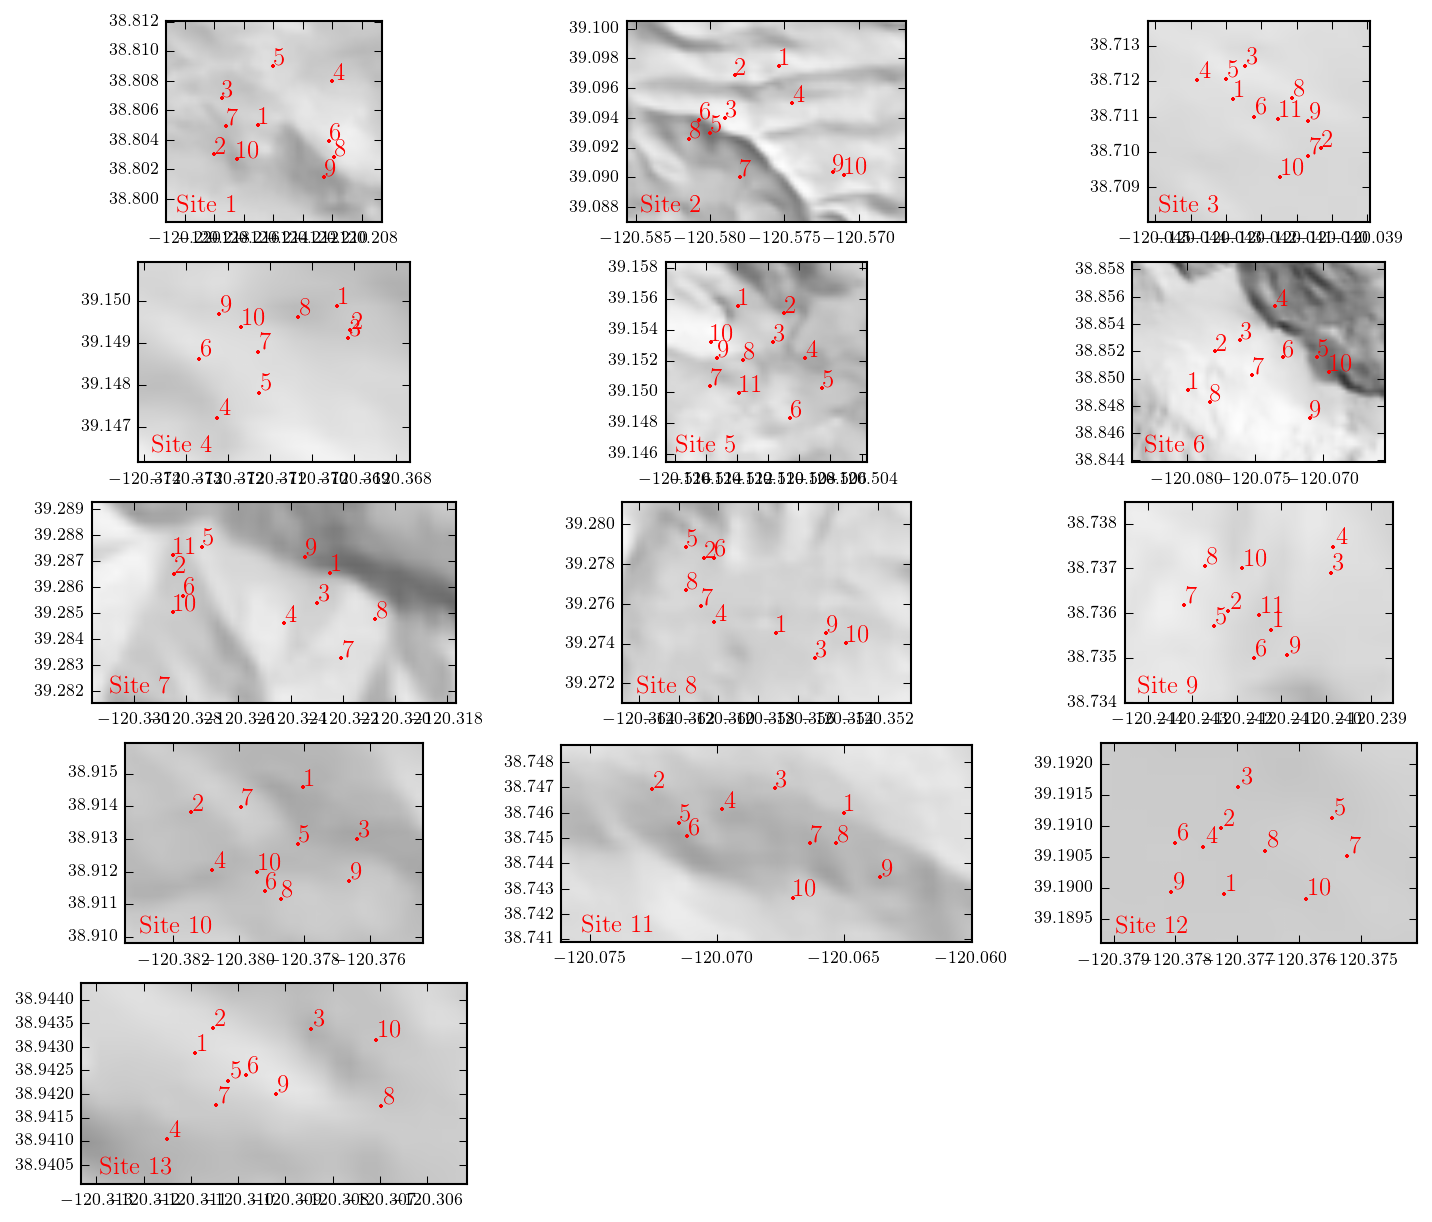

In [15]:
plt.figure(figsize=(12,10))

n_sites = df['site_id'].max() 
for i_site in range(1, n_sites+1):
    plt.subplot(5, 3, i_site)
    idx = df['site_id']==i_site
    
    lats, lons = df['lat'][idx], df['lon'][idx]
    
    # Read out the metadata.
    geotransform = dataset1.GetGeoTransform()
    origin = geotransform[0], geotransform[3]
    dlon, dlat = geotransform[1], geotransform[5]
    
    # Plot the topographical data 
    im = plt.imshow(shaded, extent=extent, aspect=1, cmap='gray',)
    #plt.colorbar()

    lon, lat = lons[idx], lats[idx]
    plt.scatter(lon, lat, s=5, c='r', marker='+')
    dlon_total = lon.max()-lon.min()
    dlat_total = lat.max()-lat.min()
    
    plt.xlim(lon.min()-.4*dlon_total, lon.max()+.4*dlon_total)
    plt.ylim(lat.min()-.4*dlat_total, lat.max()+.4*dlat_total)
    plt.gca().ticklabel_format(useOffset=False)
    n_sites = df['site_id'].max() 
    
    
    idx = np.where(df['site_id'].values==i_site)[0]
    node_lats, node_lons = df['lat'][idx].values, df['lon'][idx].values
    
    plt.text(.05, .05, 'Site %i'%(i_site), transform=plt.gca().transAxes, color='r')
    
    for i_node in range(0, len(idx)):
        plt.text(node_lons[i_node]+.00005, node_lats[i_node]+.00005, '%i'%(i_node+1), color='r')
        
        
    

Sum of Absolute Elevation Errors 3588.45571683


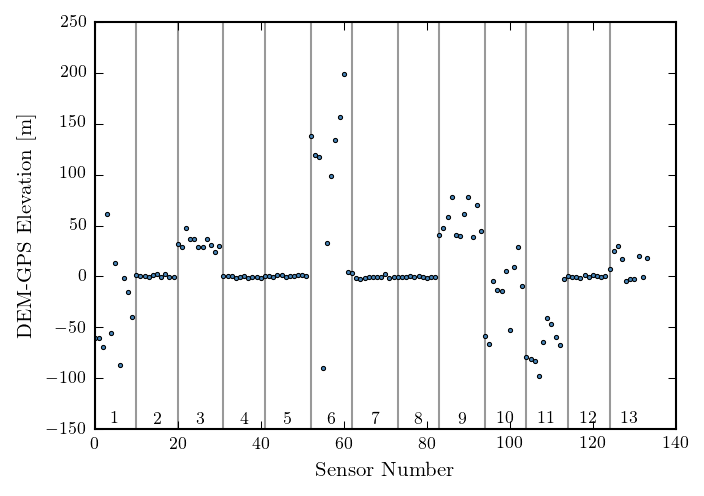

In [64]:
from scipy.interpolate import RegularGridInterpolator as RGI

def InterpolateGrid(lon, lat, arr):
    # Use bilinear interpolation
    lats = np.linspace(origin[1]+dlat*arr.shape[0] , origin[1], arr.shape[0]) 
    lons = np.linspace(origin[0], origin[0]+dlon*arr.shape[1], arr.shape[1])     
    rgi = RGI( (lats, lons), arr[::-1,] )
    return rgi((lat,lon))
    
# Check that the DEM data is pretty close to the actual elevation 
dem_elevation = InterpolateGrid(df['lon'].values, df['lat'].values, arr)
dem_slopes = InterpolateGrid(df['lon'].values, df['lat'].values, 90-slope)
dem_aspect = InterpolateGrid(df['lon'].values, df['lat'].values, np.rad2deg(aspect))
dem_aspect[dem_aspect<0] += 360 

# Plot the elevation error compared with the sensor metadata values
plt.plot(dem_elevation - df['elevation'].values, linestyle='', marker='o', markersize=2)
print 'Sum of Absolute Elevation Errors', np.sum(np.abs(dem_elevation - df['elevation'].values))
plt.ylabel('DEM-GPS Elevation [m]')
plt.xlabel('Sensor Number')

running_count = 0 
for i_site in range(1, n_sites+1):
    idx = np.where(df['site_id']==i_site)[0]
    node_count = len(idx) 
    plt.vlines(running_count, -150,250,alpha=.4)
    running_count += node_count
    plt.text(running_count-.5*(node_count), -145, '%i'%i_site, horizontalalignment='center', fontsize=8)

In [65]:
df['slope'] = dem_slopes
df['aspect'] = dem_aspect


In [66]:
df.to_csv('../raw_data/metadata_clean_with_slope_aspect.csv')

In [68]:
df2 = pd.read_csv('../raw_data/metadata_clean_with_slope_aspect.csv')
df[df2['site_id']==6]


Unnamed: 0  mote_id  site_id  node_id        lat         lon  elevation  \
52          52       53        6        1  38.849152 -120.079865     2338.0   
53          53       54        6        2  38.851990 -120.077919     2488.0   
54          54       55        6        3  38.852829 -120.076080     2545.0   
55          55       56        6        4  38.855282 -120.073502     2680.0   
56          56       57        6        5  38.851566 -120.070419     2607.0   
57          57       58        6        6  38.851543 -120.072945     2570.0   
58          58       59        6        7  38.850246 -120.075203     2451.0   
59          59       60        6        8  38.848282 -120.078316     2306.0   
60          60       61        6        9  38.847118 -120.070976     2376.0   
61          61       62        6       10  38.850498 -120.069542     2577.0   

      put_time     mac sd_last_update   server_last_update  \
52  2016-03-07  3828e0            NaN  2016-05-11 06:00:00   
53  2016-03-07  38294c            NaN  2016-01-13 16:15:00   
54  2016-03-07  382a19            NaN  2015-11-24 20:30:00   
55  2016-03-07  3828b1            NaN  2016-02-19 11:30:00   
56  2016-03-07  382a77            NaN  2016-05-11 06:00:00   
57  2016-03-07  38350f            NaN  2016-05-11 06:00:00   
58  2016-03-07  383985            NaN  2016-05-11 06:00:00   
59  2016-03-07  382a11            NaN  2016-05-11 06:00:00   
60  2016-03-07  383be2            NaN  2016-04-29 05:15:00   
61  2016-03-07  3828e6            NaN  2016-03-14 02:30:00   

             sd_level_1       server_level_1  ground_dist      slope  \
52  2014-10-01 00:00:00  2014-10-01 00:00:00      4295.79  20.324207   
53  2014-10-01 00:00:00  2014-10-01 00:00:00      4012.77  17.607461   
54  2014-10-01 00:00:00  2014-10-01 00:00:00      4596.47  15.468055   
55  2014-10-01 00:00:00  2014-10-01 00:00:00      3113.78  20.713407   
56  2014-10-01 00:00:00  2014-10-01 00:00:00      3660.67  36.595110   
57  2014-10-01 00:00:00  2014-10-01 00:00:00      4330.20  13.372584   
58  2014-10-01 00:00:00  2014-10-01 00:00:00      4181.35  26.232336   
59  2014-10-01 00:00:00  2014-10-01 00:00:00      4346.00  25.708869   
60  2014-10-01 00:00:00  2014-10-01 00:00:00      4305.77  27.850409   
61  2014-10-01 00:00:00  2014-10-01 00:00:00      4357.36  34.530554   

        aspect  
52 -153.825811  
53 -136.767605  
54 -134.210513  
55   19.715969  
56   95.495989  
57 -176.502133  
58 -129.162842  
59 -160.813906  
60 -165.196142  
61   58.784113